In [1]:
#from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import layers

import pandas as pd
import numpy as np
import os

import librosa as l
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import imblearn

# Keras
import keras
import keras_metrics
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.optimizers import RMSprop

In [2]:
#%pip install keras_metrics

In [3]:
final_df = pd.read_csv('../Datasets/final_df.csv')

# drop first column
final_df.drop('Unnamed: 0', axis='columns', inplace=True)

# train-test split dataset
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

final_df_testing = final_df.copy()
final_df_testing = shuffle(final_df_testing)

X = final_df_testing.drop(columns=['Path', 'Emotions_without_gender','Emotions_with_gender'], axis=1)
y = final_df_testing['Emotions_with_gender']
print(X.shape, y.shape)

(11682, 173) (11682,)


In [4]:
# Handle imbalance classes with SMOTE
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

print('Original dataset shape', Counter(y))
print('\n')
print('Resample dataset shape', Counter(y_smote))

Original dataset shape Counter({3: 1096, 4: 1096, 0: 1096, 6: 1096, 2: 1096, 5: 960, 12: 767, 8: 767, 10: 767, 11: 767, 14: 767, 13: 623, 7: 496, 9: 96, 15: 96, 1: 96})


Resample dataset shape Counter({3: 1096, 4: 1096, 0: 1096, 5: 1096, 12: 1096, 8: 1096, 13: 1096, 10: 1096, 11: 1096, 6: 1096, 14: 1096, 7: 1096, 2: 1096, 9: 1096, 15: 1096, 1: 1096})


In [5]:
X_train

,MFCC0,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,...,MEL124,MEL125,MEL126,MEL127,TONZ0,TONZ1,TONZ2,TONZ3,TONZ4,TONZ5
4216,-384.656560,146.756400,7.473134,53.037930,-7.313989,18.064383,-16.401203,7.368804,-14.423988,-3.495318,...,1.639884e-09,1.605576e-09,1.583187e-09,1.569325e-09,0.023146,-0.011530,-0.106588,-0.061734,-0.001138,-0.012873
13474,-383.213164,146.584691,7.202562,61.148175,-16.740930,6.566938,-15.999932,6.479111,-17.384601,1.901310,...,9.940465e-09,9.771188e-09,9.662842e-09,9.595200e-09,-0.014890,-0.035780,-0.038620,-0.033143,0.003534,0.008552
2344,-427.640600,141.422560,12.171227,59.142315,-11.924521,23.197508,-14.343899,8.493648,-15.210551,3.693683,...,2.012429e-12,1.831967e-12,1.712254e-12,1.641931e-12,0.034555,-0.019315,-0.095615,-0.022239,0.019591,0.013062
15889,-379.981214,136.398738,6.753225,48.319042,-10.533706,18.760793,-10.650267,3.665365,-15.603375,0.487222,...,4.394655e-09,4.300762e-09,4.239769e-09,4.202175e-09,-0.014300,-0.013350,-0.070752,-0.006849,0.015142,-0.001796
15538,-343.108865,132.974755,13.365400,42.617032,-11.101250,3.140729,-11.174173,3.531970,-18.034601,0.090984,...,3.220081e-09,3.161370e-09,3.123617e-09,3.100093e-09,0.022404,-0.045688,-0.072841,0.007506,0.000113,0.005244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,-378.178220,32.139515,2.981272,15.586564,-17.983126,-8.710560,-1.867216,-14.102924,-11.300590,5.833367,...,2.619235e-03,2.643978e-03,2.007598e-03,2.473368e-04,0.008198,-0.020456,-0.028001,0.012752,0.003514,0.008401
11964,-657.803954,47.584022,-6.362550,5.331894,-6.058957,-2.237435,-6.588158,-9.873861,-5.084711,-2.170359,...,2.820547e-05,3.428624e-05,2.194737e-05,2.000995e-06,-0.017593,0.042185,0.017522,-0.021688,0.021498,-0.005105
5390,-288.909360,126.207680,-10.763977,30.590635,-22.421060,11.265186,-4.736027,-7.798991,-21.748080,5.943014,...,8.126718e-10,8.001545e-10,7.922667e-10,7.871842e-10,-0.037821,0.030018,-0.050963,-0.009212,0.011865,-0.006997
860,-437.461880,150.991970,12.801816,61.403786,-12.044663,27.356472,-18.676830,15.905809,-11.027823,2.625805,...,8.010991e-09,7.863581e-09,7.768693e-09,7.709718e-09,-0.000245,-0.031358,-0.041107,-0.003010,0.019845,0.003539


In [6]:
#X_smote.shape[1], 1
X_smote.shape[1], 1

(173, 1)

In [7]:
model = tf.keras.Sequential()

model.add(layers.Conv1D(128, kernel_size=5, strides=1, # first convulational layer
                        padding="same", activation="relu",
                        input_shape=(X_smote.shape[1], 1))) 
#model.add(layers.MaxPool1D(pool_size=2, strides=2, padding="same"))

model.add(layers.Conv1D(64, kernel_size=5, strides=1,  # second convulational layer
                        padding="same", activation="relu"))
#model.add(layers.MaxPool1D(pool_size=2, strides=2, padding="same"))

model.add(layers.Flatten()) # flatten into a 1D array
model.add(layers.Dense(128, activation='relu')) # fully connected layer
model.add(layers.Dense(64, activation='relu')) # fully connected layer

model.add(layers.Dense(16, activation="softmax")) # output layer

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 173, 128)          768       
                                                                 
 conv1d_1 (Conv1D)           (None, 173, 64)           41024     
                                                                 
 flatten (Flatten)           (None, 11072)             0         
                                                                 
 dense (Dense)               (None, 128)               1417344   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
Total params: 1468432 (5.60 MB)
Trainable params: 14684

## Applying regularisation (Early Stopping) to monitor the model's performance on a separate validation dataset during training - If the validation loss did not improve after 10 epochs, the training will stop.


In [8]:
from tensorflow.keras import layers, models, callbacks

# Compile the model with appropriate Loss function
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              run_eagerly=True)

#sparse_categorical_crossentropy --> when targets are integer & suitable for multiclasses
#categorical_crossentropy --> when targets are one-hot encoded vectors (binary) 

# Regularisation - Define early stopping callback 
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)

epochs = 100

history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test,y_test), callbacks=[early_stopping]) 

Epoch 1/100

439/439 [==============================] - 18s 40ms/step - loss: 1.9442 - accuracy: 0.3831 - val_loss: 1.5444 - val_accuracy: 0.4974
Epoch 2/100
439/439 [==============================] - 18s 40ms/step - loss: 1.3997 - accuracy: 0.5391 - val_loss: 1.2779 - val_accuracy: 0.5716
Epoch 3/100
439/439 [==============================] - 18s 40ms/step - loss: 1.2316 - accuracy: 0.5857 - val_loss: 1.1860 - val_accuracy: 0.6063
Epoch 4/100
439/439 [==============================] - 18s 40ms/step - loss: 1.1458 - accuracy: 0.6088 - val_loss: 1.1855 - val_accuracy: 0.6003
Epoch 5/100
439/439 [==============================] - 18s 40ms/step - loss: 1.0909 - accuracy: 0.6239 - val_loss: 1.0838 - val_accuracy: 0.6263
Epoch 6/100
439/439 [==============================] - 18s 40ms/step - loss: 1.0369 - accuracy: 0.6387 - val_loss: 1.0986 - val_accuracy: 0.6286
Epoch 7/100
439/439 [==============================] - 18s 41ms/step - loss: 0.9953 - accuracy: 0.6502 - val_loss: 1.0372 - val_a

## In this case, the model stopped at 41 epochs.

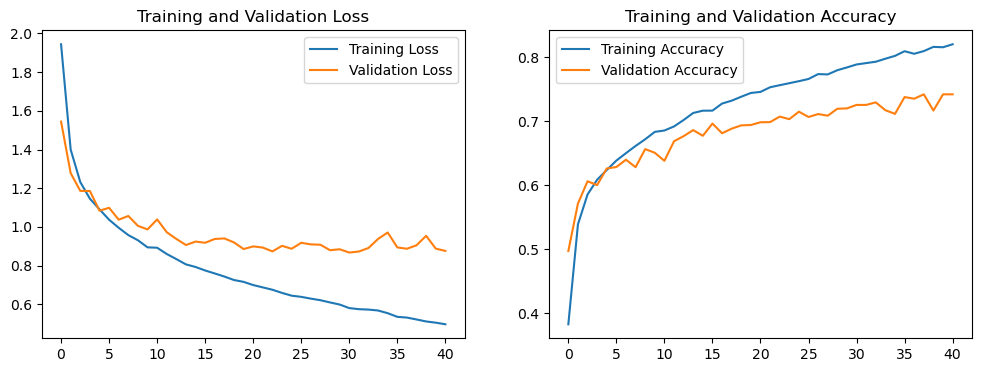

In [9]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Make predictions and calculate metrics
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

# Calculate Precision, Recall, F1-Score
precision = precision_score(y_test, predicted_classes, average='weighted')
recall = recall_score(y_test, predicted_classes, average='weighted')
f1 = f1_score(y_test, predicted_classes, average='weighted')

print(f"Precision: {precision}, Recall: {recall}, F1-Score: {f1}")

print("\n")

# For a detailed classification report including precision, recall, f1-score per class
print(classification_report(y_test, predicted_classes))

110/110 [==============================] - 1s 6ms/step
Precision: 0.7451009834012514, Recall: 0.742018244013683, F1-Score: 0.7393556941880237


              precision    recall  f1-score   support

           0       0.77      0.77      0.77       233
           1       0.94      1.00      0.97       213
           2       0.60      0.73      0.66       215
           3       0.74      0.67      0.70       236
           4       0.76      0.68      0.72       211
           5       0.64      0.83      0.72       221
           6       0.77      0.62      0.69       232
           7       0.96      0.97      0.97       227
           8       0.79      0.73      0.76       226
           9       0.97      1.00      0.99       202
          10       0.66      0.48      0.56       217
          11       0.58      0.47      0.52       218
          12       0.55      0.65      0.59       223
          13       0.58      0.73      0.65       195
          14       0.67      0.61      0.64  

## Based on this, 41 seems to be the optimal (highest accuracy with the least loss) number of epochs to train the model with.